In [31]:
import gym
import math
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [32]:
env = gym.make('ALE/SpaceInvaders-v5')


numAcciones = env.action_space.n
epsilon = 0.99
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training with:", device)

Training with: cuda


In [33]:
def get_image():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    resize = T.Compose([T.ToPILImage(),
                    #T.Resize(95, interpolation=Image.CUBIC),
                    T.Grayscale(num_output_channels=1),
                    T.ToTensor()])

    screen = resize(screen).unsqueeze(0)
    return screen

In [34]:
class Memory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def save(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [35]:
memory = Memory(10000)
BATCH_SIZE = 128

In [36]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    batch = memory.sample(BATCH_SIZE)
    ys = []
    for b in batch:
        (state, action, next_state, reward) = b

        if next_state == None: # Es final
            y = reward
        else:
            y = 0
            # y = gamma*max<a en A>target_Q(next_state, a)
    ys.append(y)
        
    loss = 0
    for i in range(len(batch)):
        (state, action, next_state, reward) = batch[i]
        # loss += (Q(state, action) - ys[i])^2
    # Update Q using the SGD algorithm by minimizing the loss
    # Every C steps, copy weights from Q to target_Q

In [37]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        """Para calcular correctamente la salida, tenemos que linealizarla, esto depende de las dimensiones
        de las imagenes de entrada y de los parámetros introducidos"""
        def conv2d_size_out(size, kernel_size = 3, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    """Devuelve un vector con el valor de las acciones posibles"""
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [38]:
screen = get_image()
_, _, screen_height, screen_width = screen.shape

red_politica = DQN(screen_height, screen_width, numAcciones).to(device)
red_objetivo = DQN(screen_height, screen_width, numAcciones).to(device)
red_objetivo.load_state_dict(red_politica.state_dict())
red_objetivo.eval()

optimizer = optim.RMSprop(red_politica.parameters())

C:\Users\Sergio\AppData\Local\Temp\ipykernel_7896\1347376400.py:7: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(95, interpolation=Image.CUBIC),


In [39]:
def action_selection(state):
    global epsilon
    e = epsilon
    epsilon = (epsilon * 99.7)/100
    if random.randint(0, 100)/100 < e:
        return torch.tensor([[random.randrange(numAcciones)]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            return  red_politica(state).max(1)[1].view(1, 1)



In [40]:
action_selection(screen)

tensor([[5]], device='cuda:0')

C:\Users\Sergio\AppData\Local\Temp\ipykernel_7896\1347376400.py:7: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(95, interpolation=Image.CUBIC),


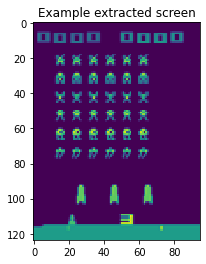

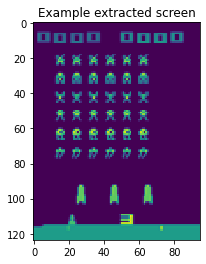

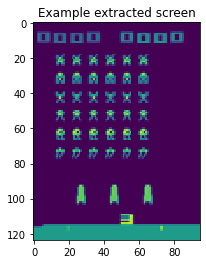

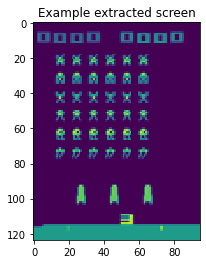

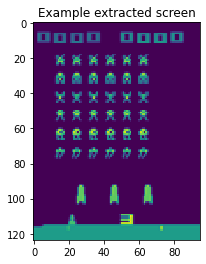

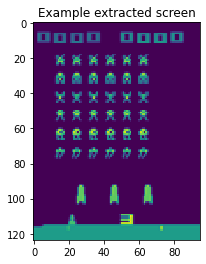

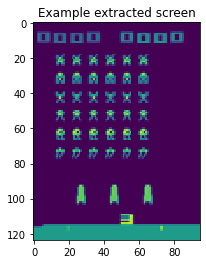

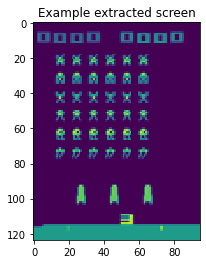

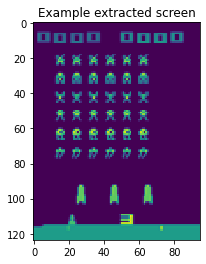

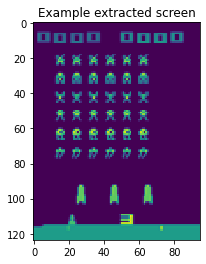

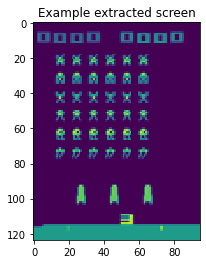

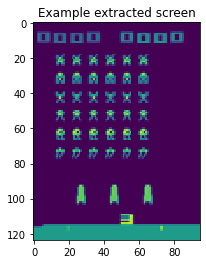

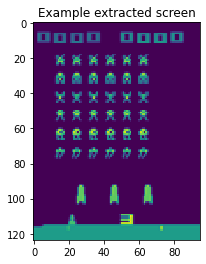

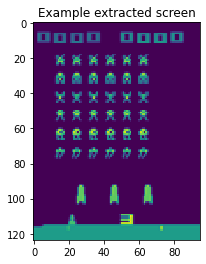

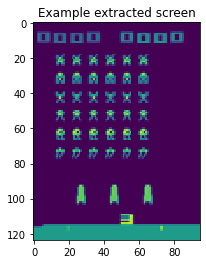

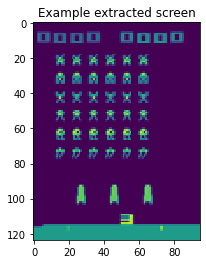

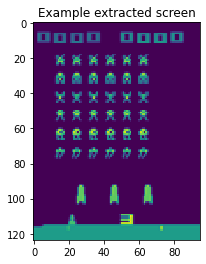

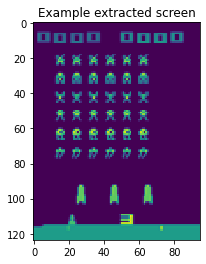

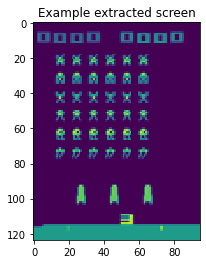

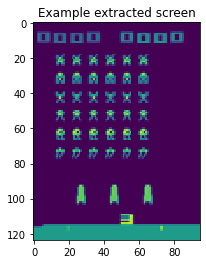

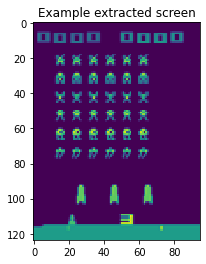

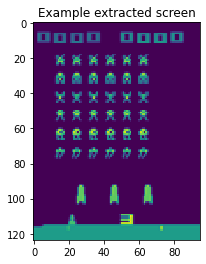

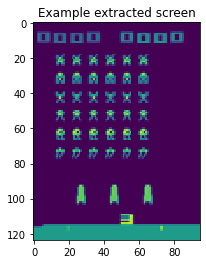

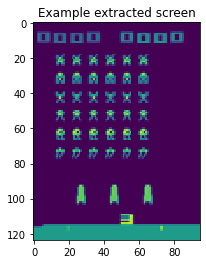

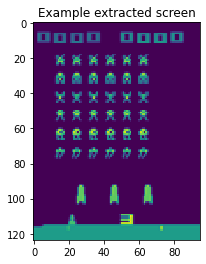

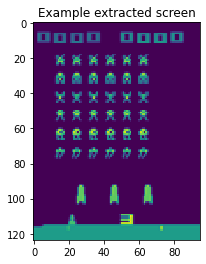

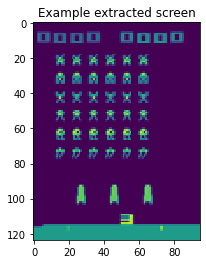

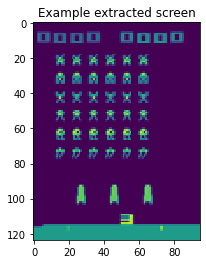

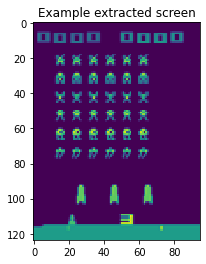

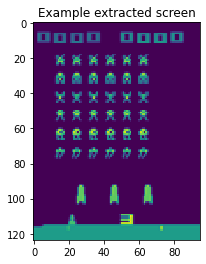

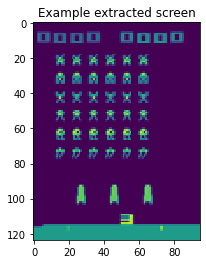

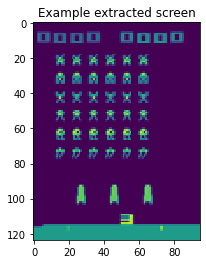

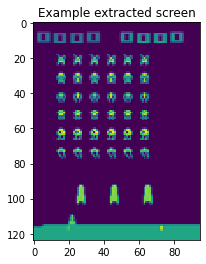

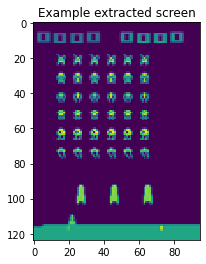

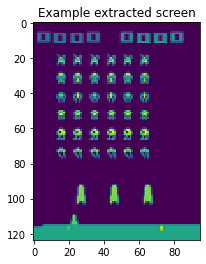

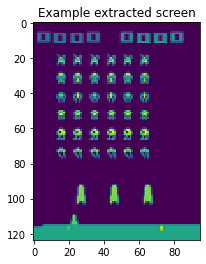

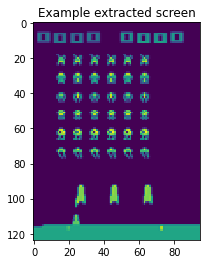

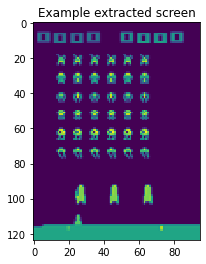

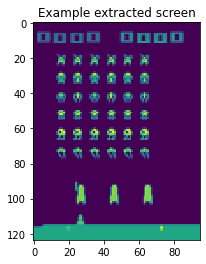

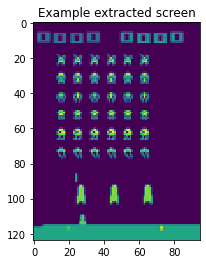

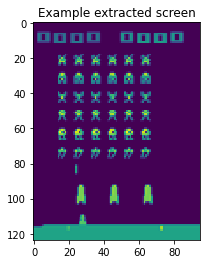

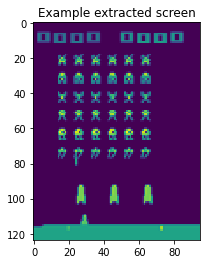

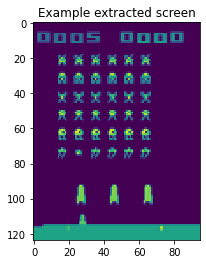

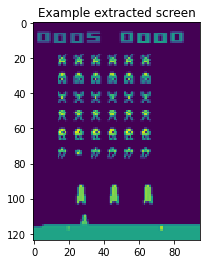

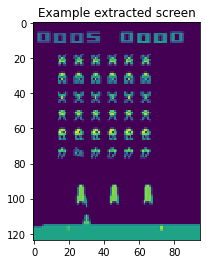

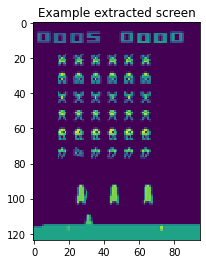

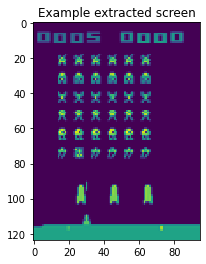

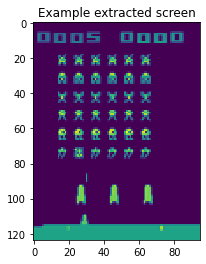

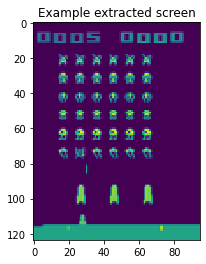

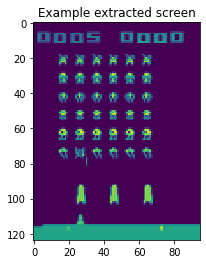

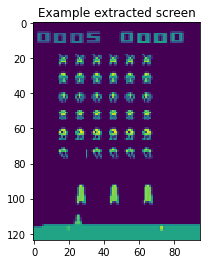

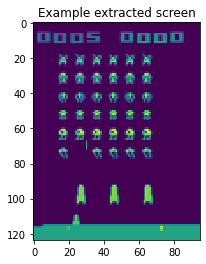

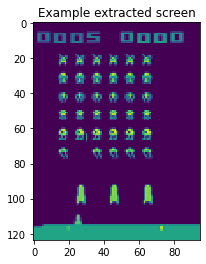

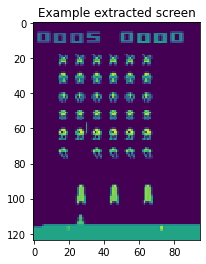

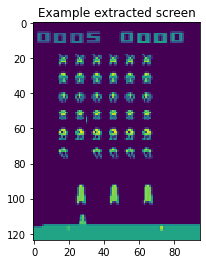

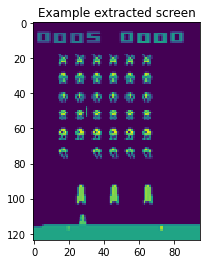

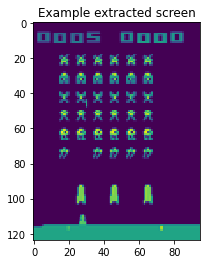

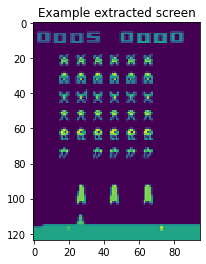

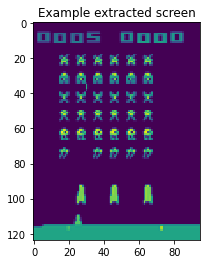

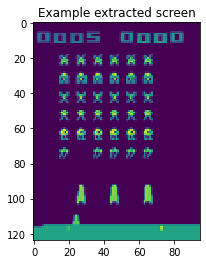

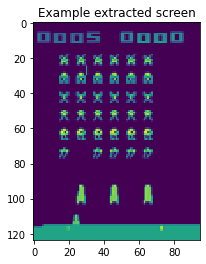

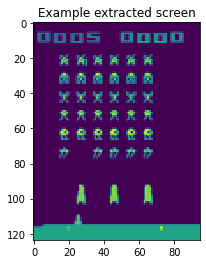

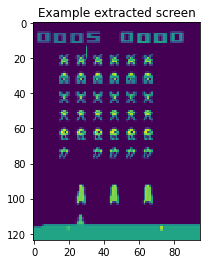

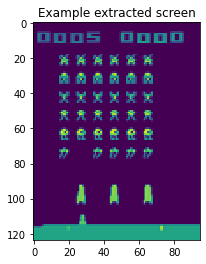

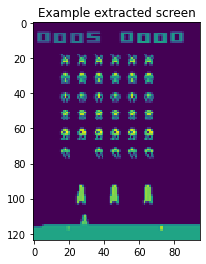

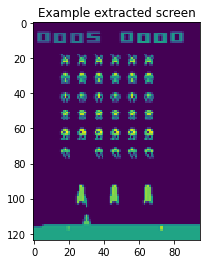

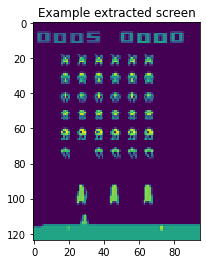

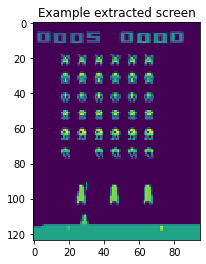

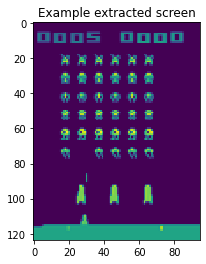

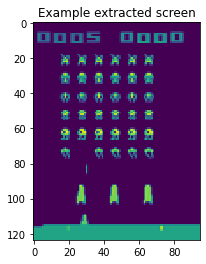

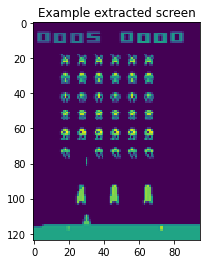

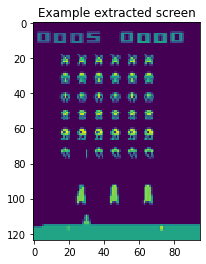

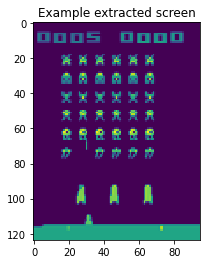

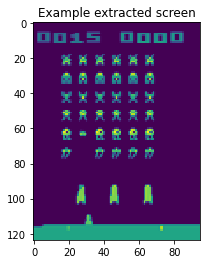

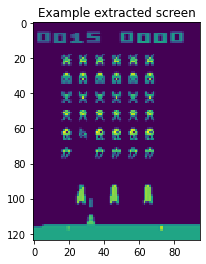

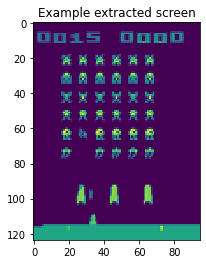

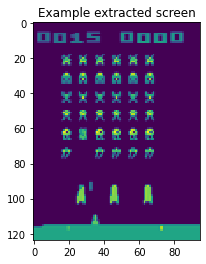

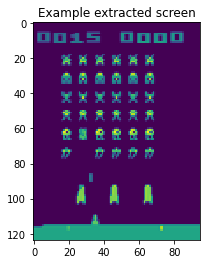

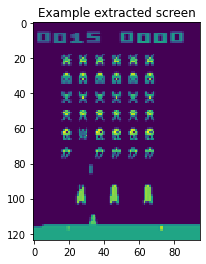

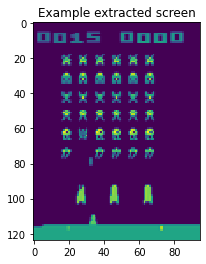

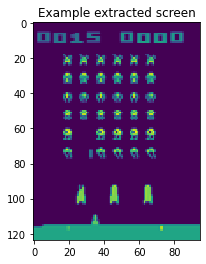

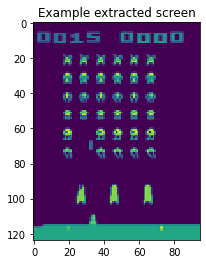

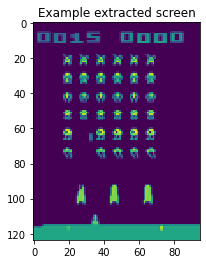

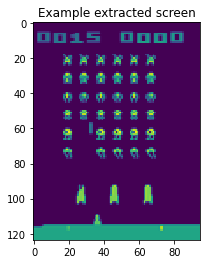

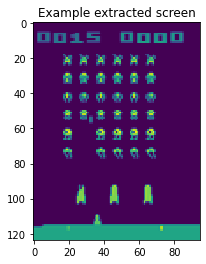

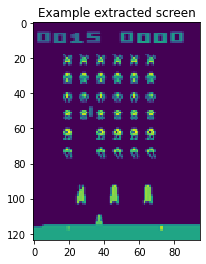

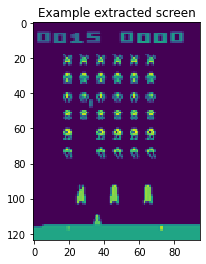

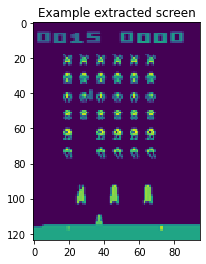

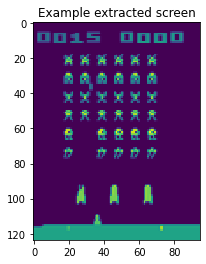

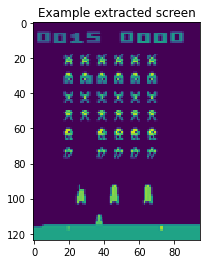

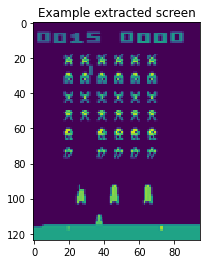

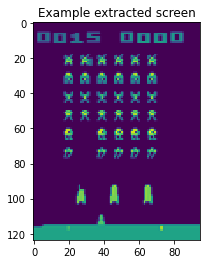

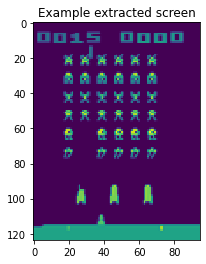

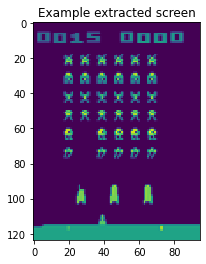

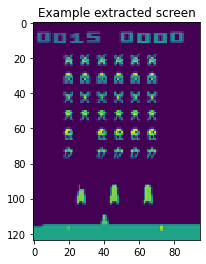

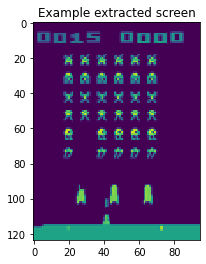

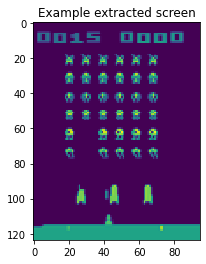

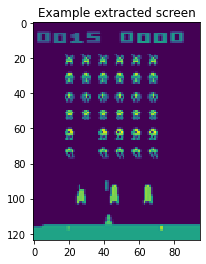

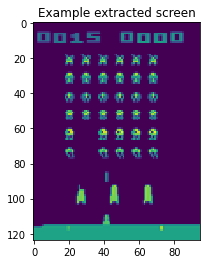

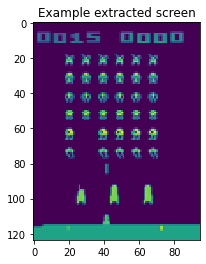

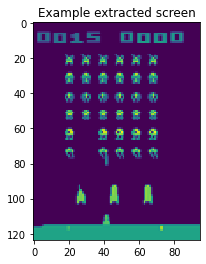

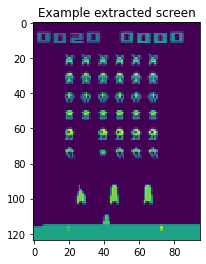

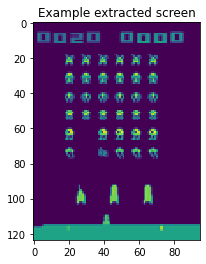

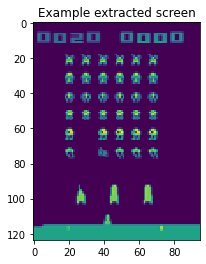

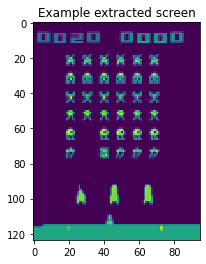

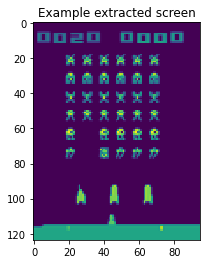

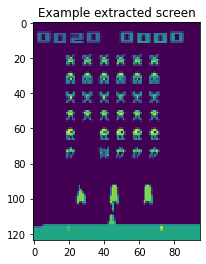

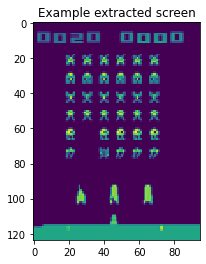

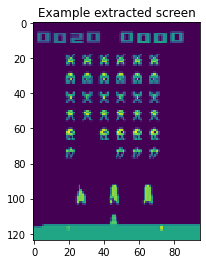

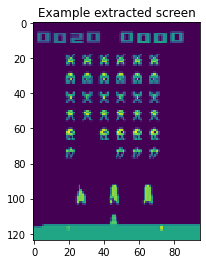

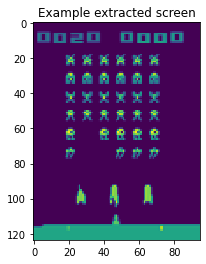

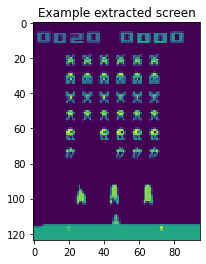

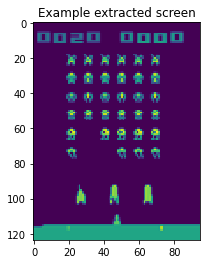

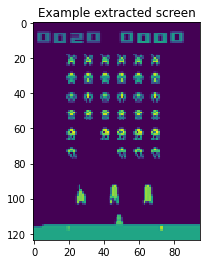

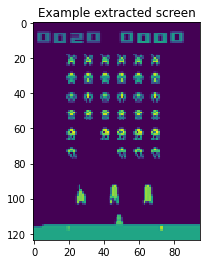

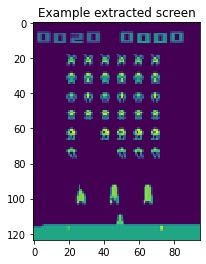

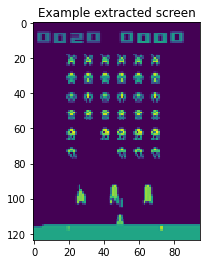

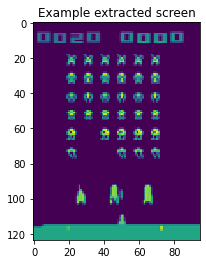

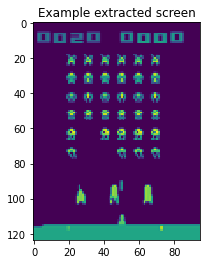

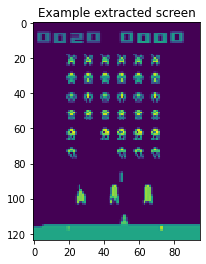

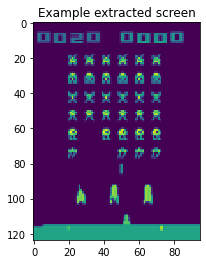

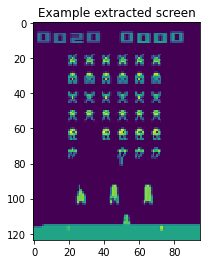

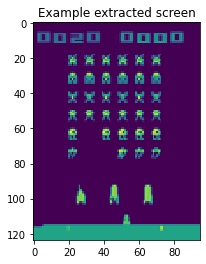

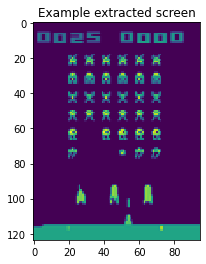

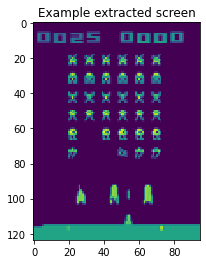

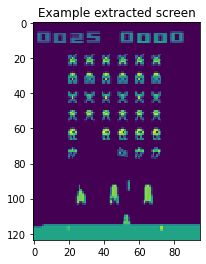

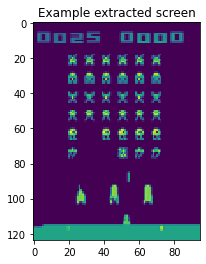

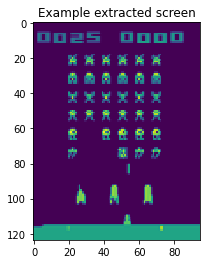

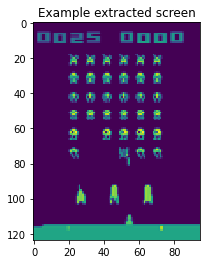

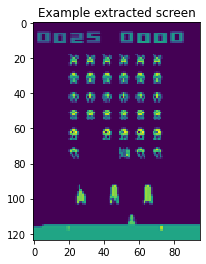

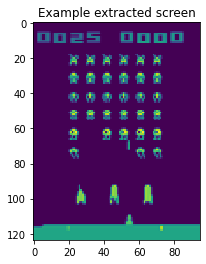

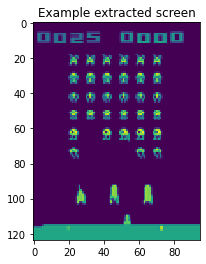

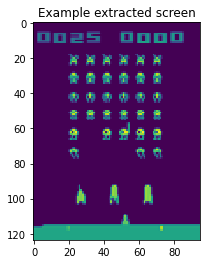

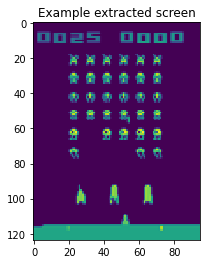

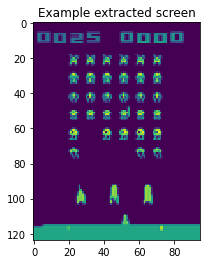

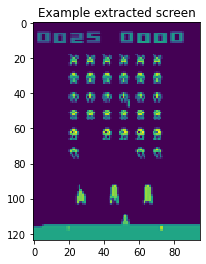

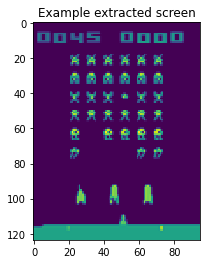

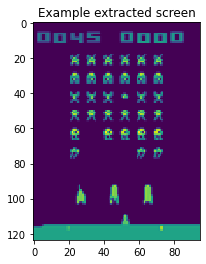

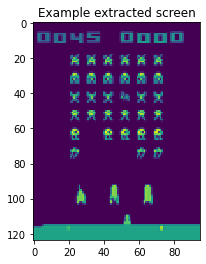

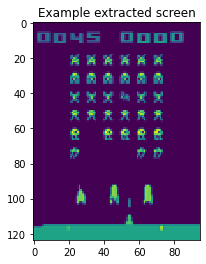

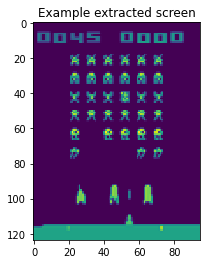

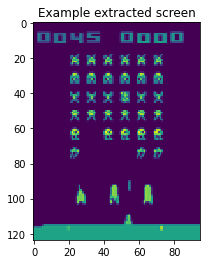

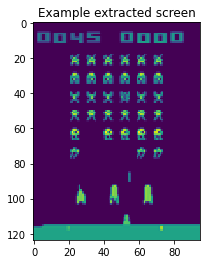

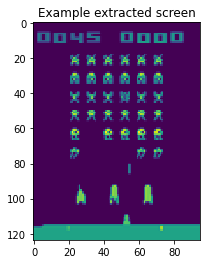

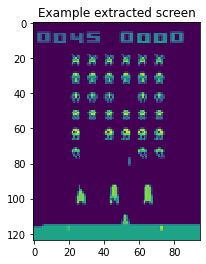

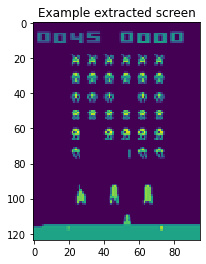

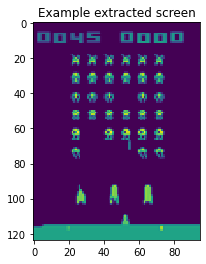

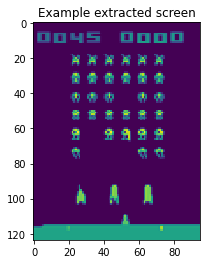

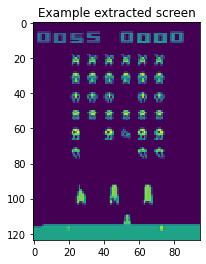

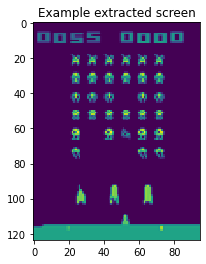

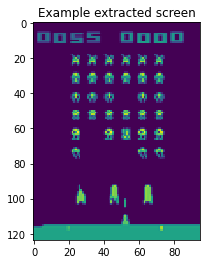

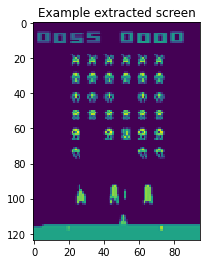

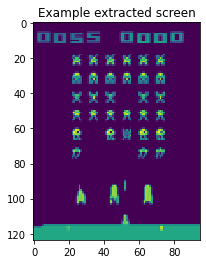

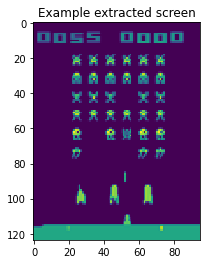

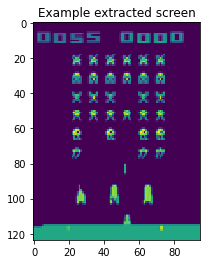

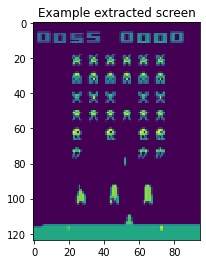

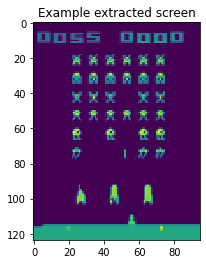

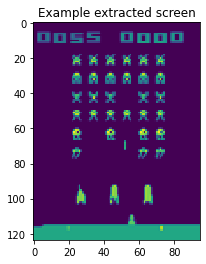

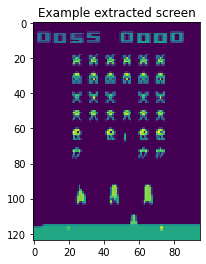

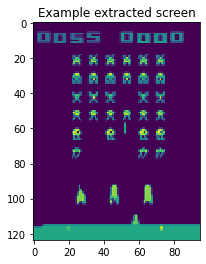

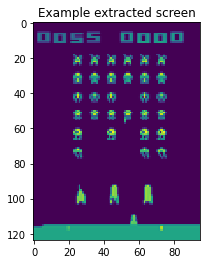

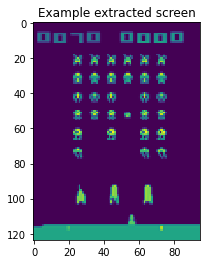

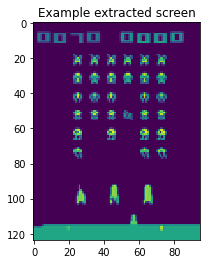

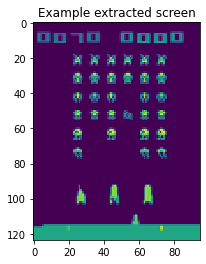

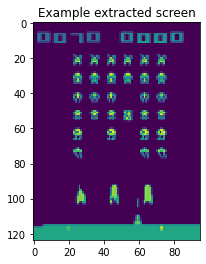

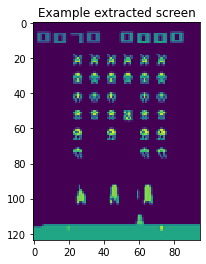

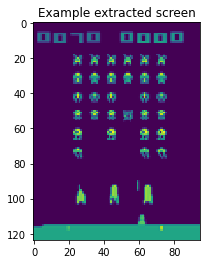

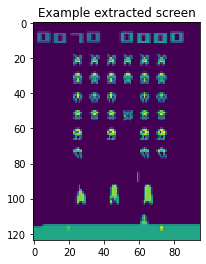

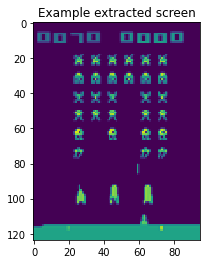

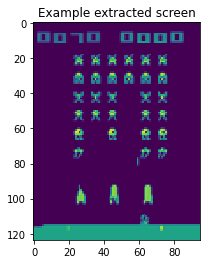

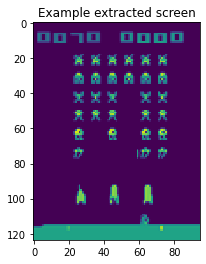

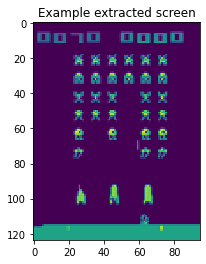

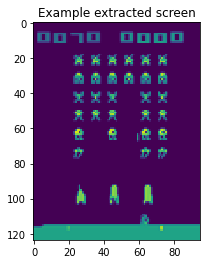

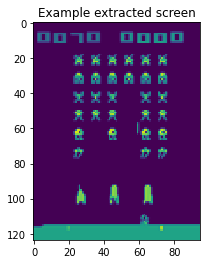

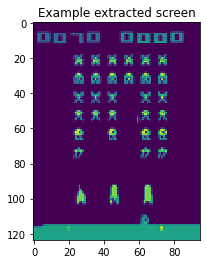

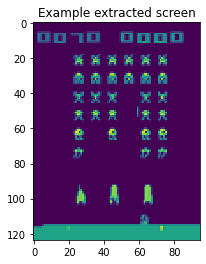

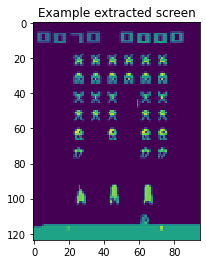

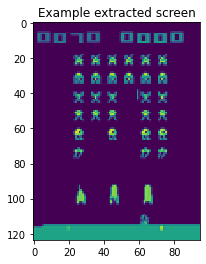

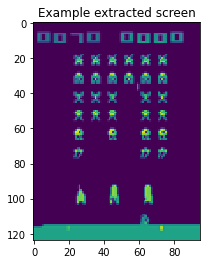

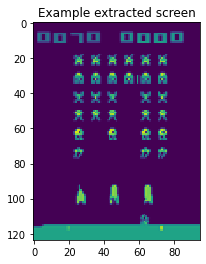

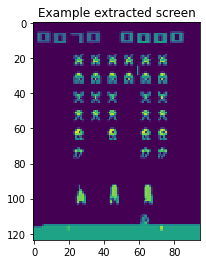

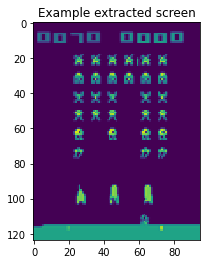

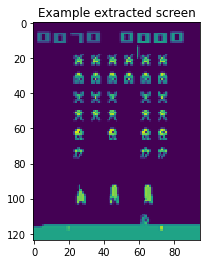

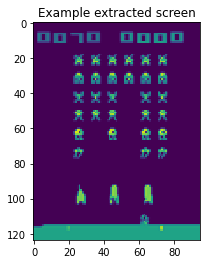

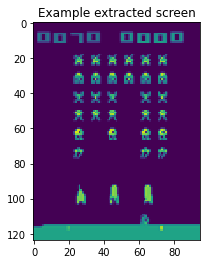

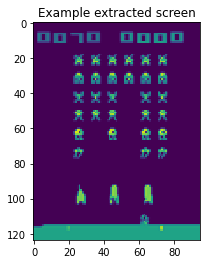

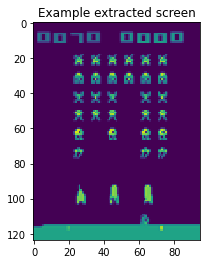

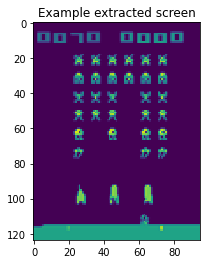

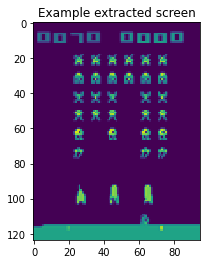

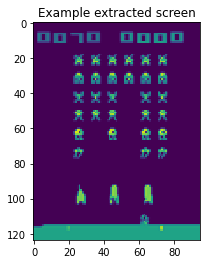

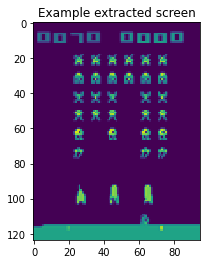

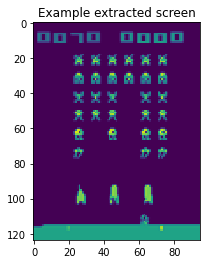

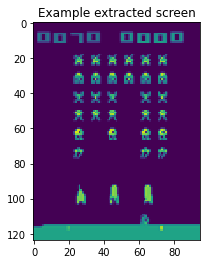

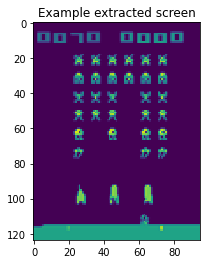

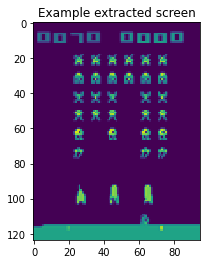

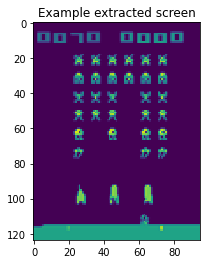

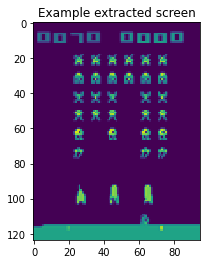

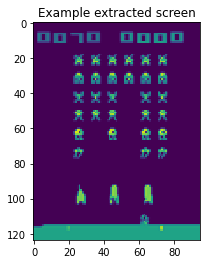

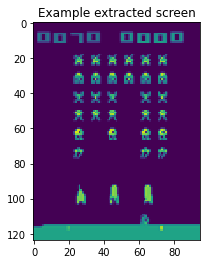

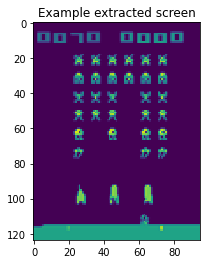

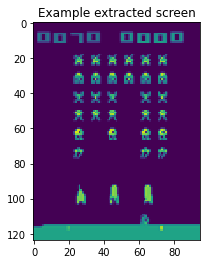

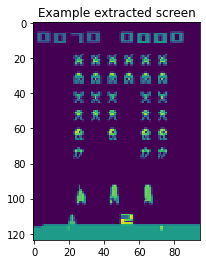

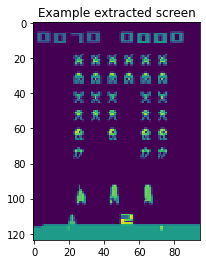

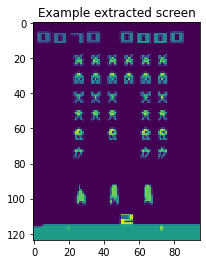

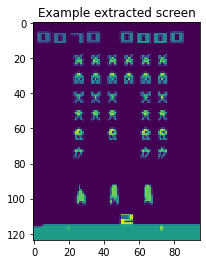

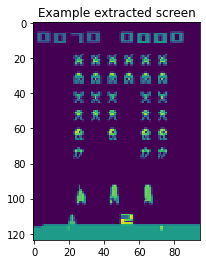

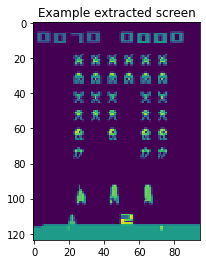

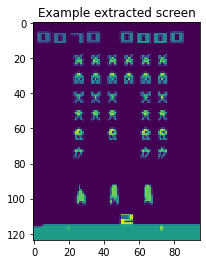

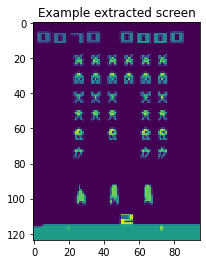

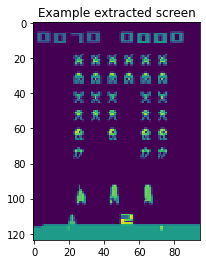

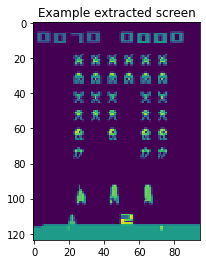

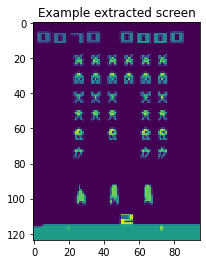

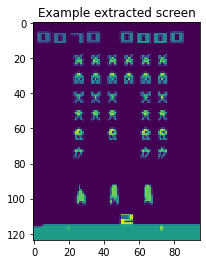

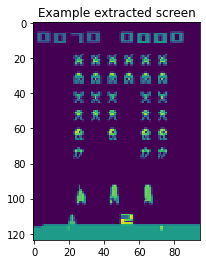

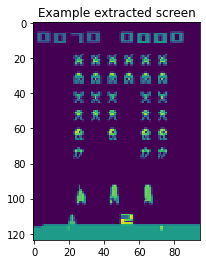

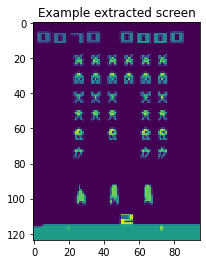

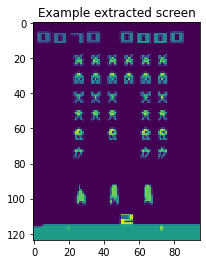

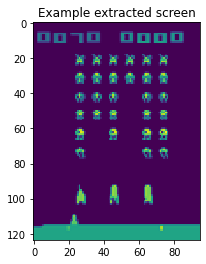

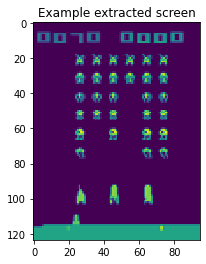

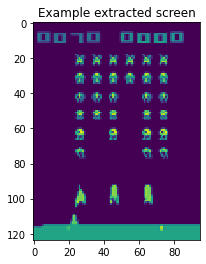

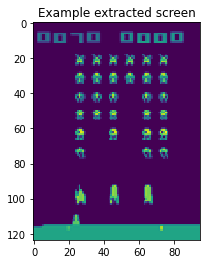

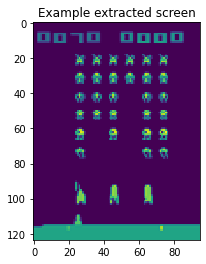

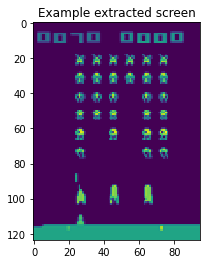

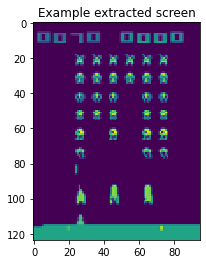

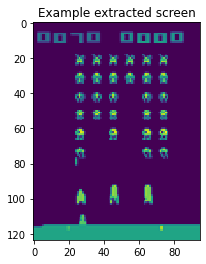

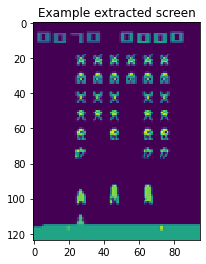

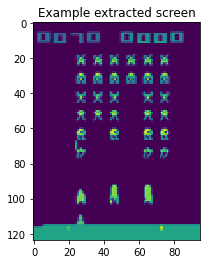

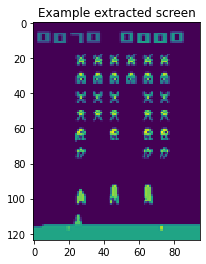

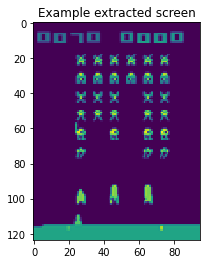

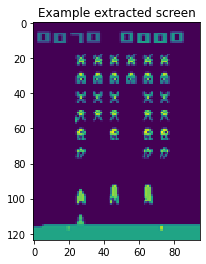

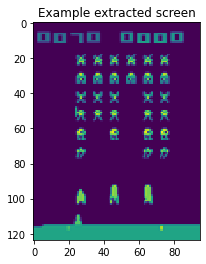

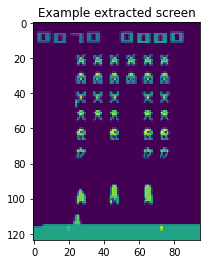

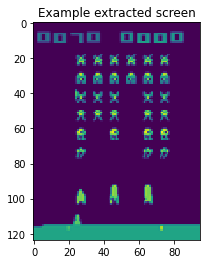

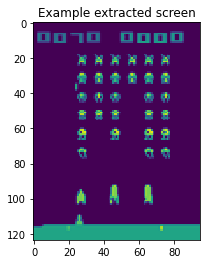

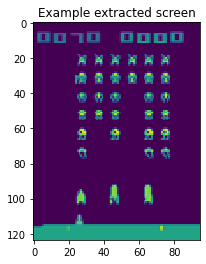

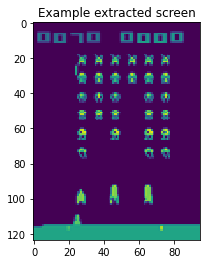

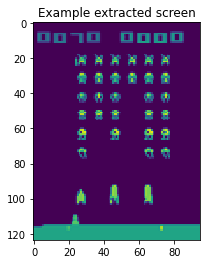

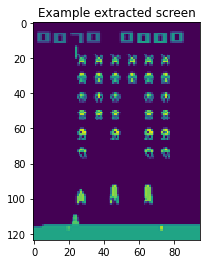

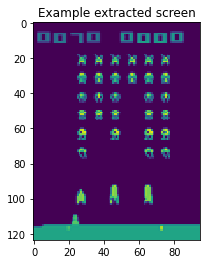

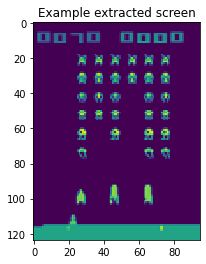

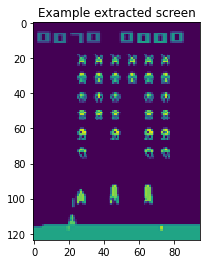

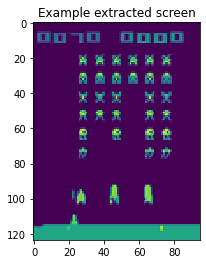

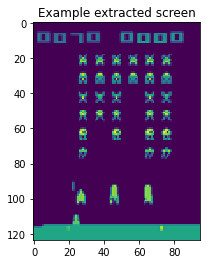

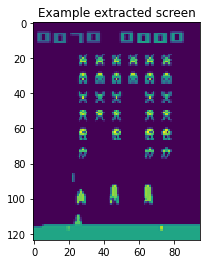

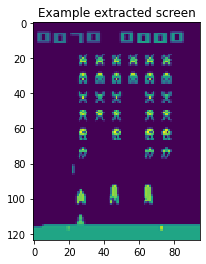

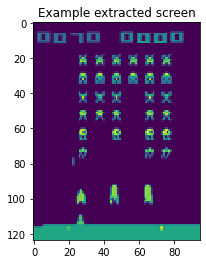

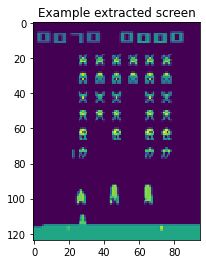

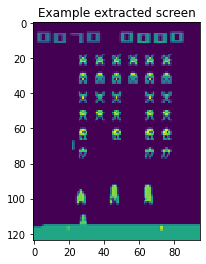

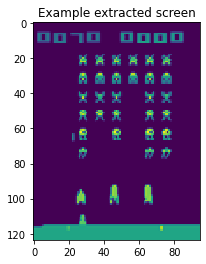

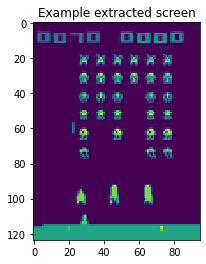

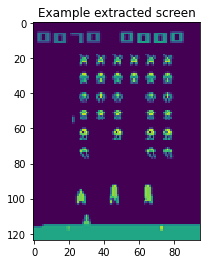

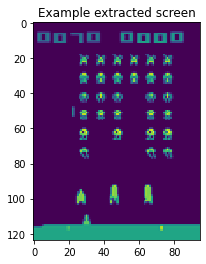

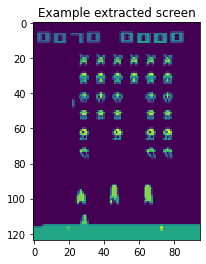

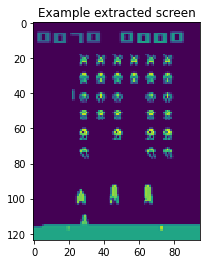

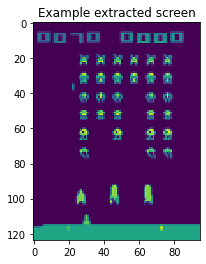

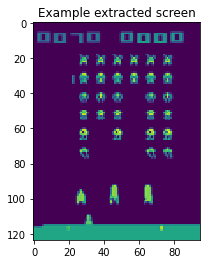

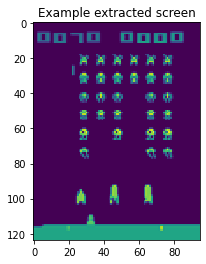

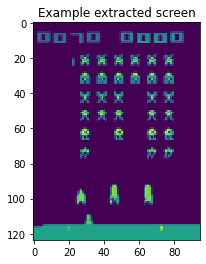

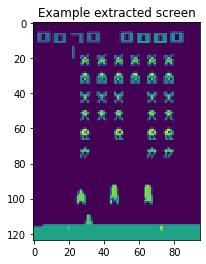

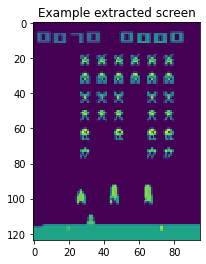

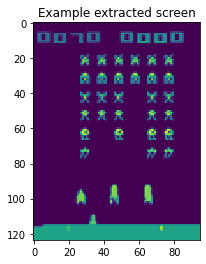

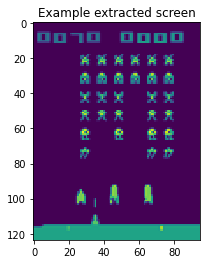

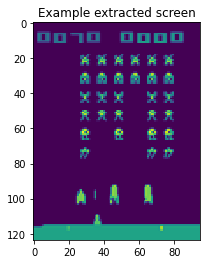

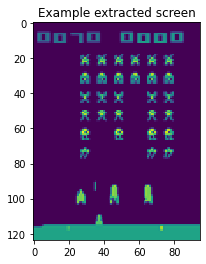

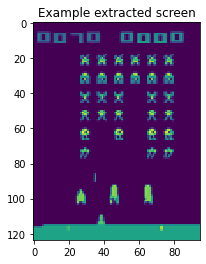

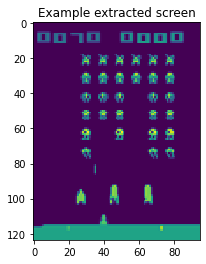

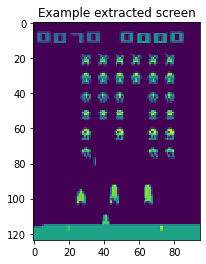

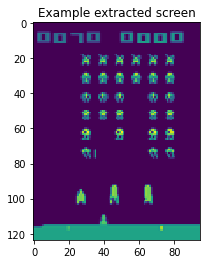

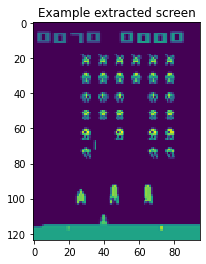

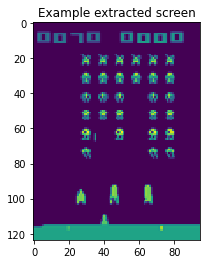

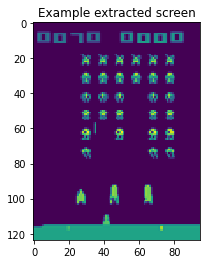

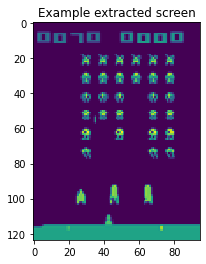

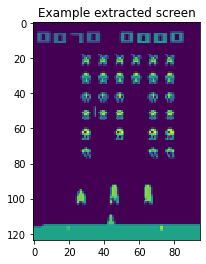

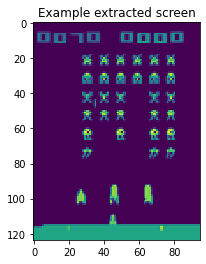

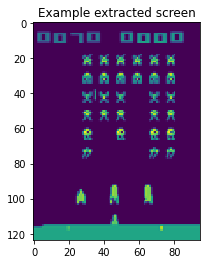

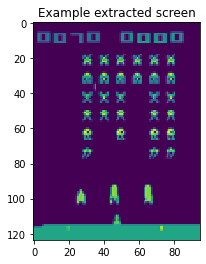

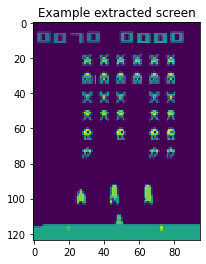

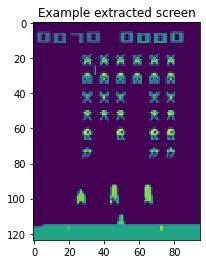

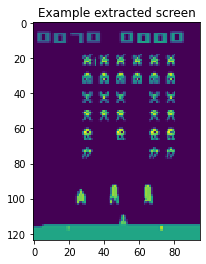

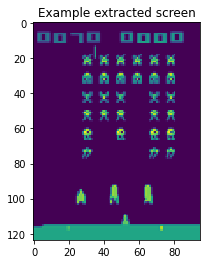

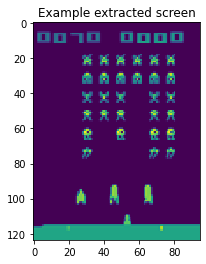

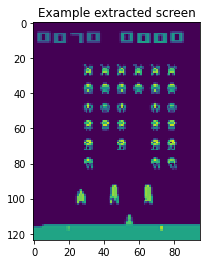

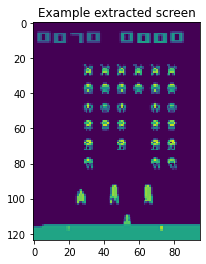

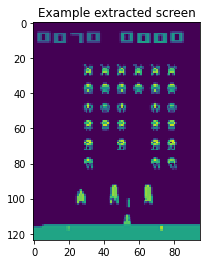

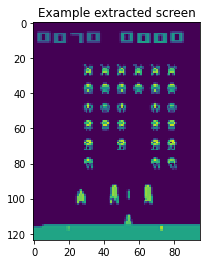

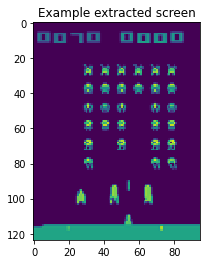

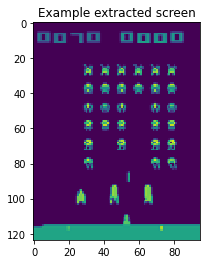

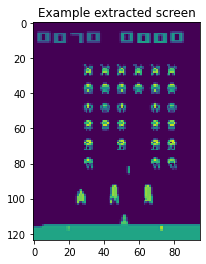

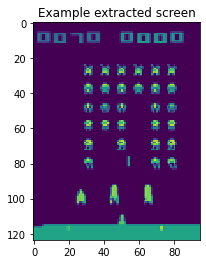

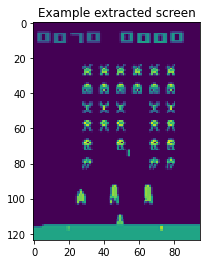

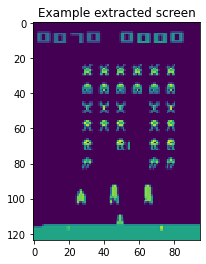

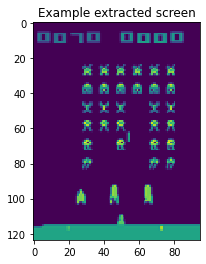

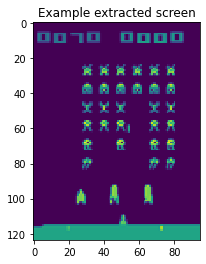

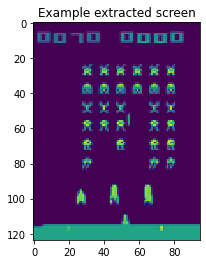

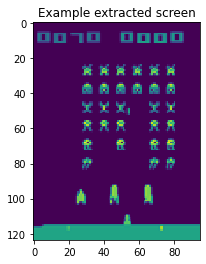

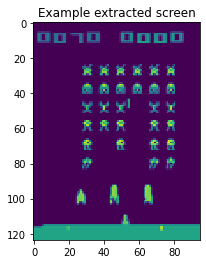

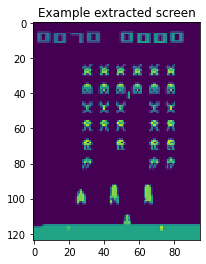

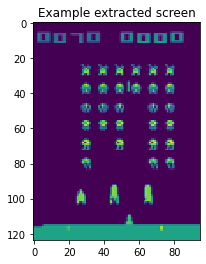

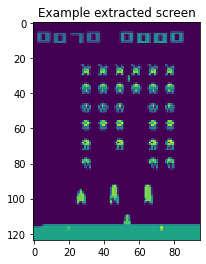

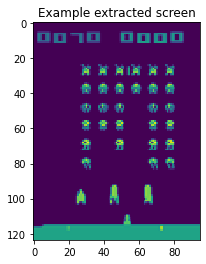

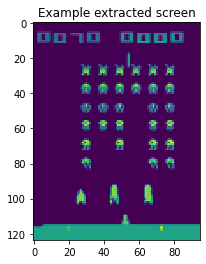

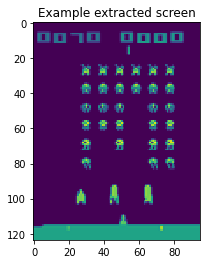

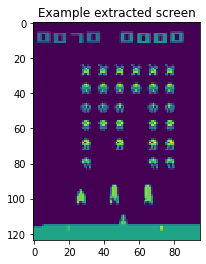

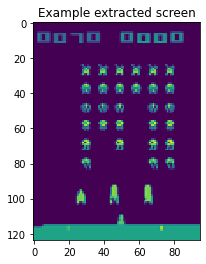

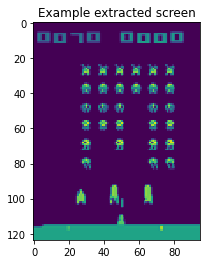

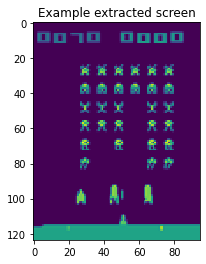

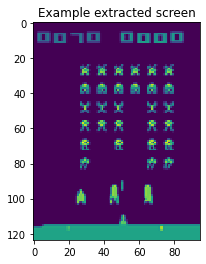

KeyboardInterrupt: 

In [41]:
episodios = 100
for i in range(episodios):
    env.reset()
    screen_1 = get_image()
    screen_2 = get_image()

    estado = screen_2-screen_1

    for j in count():
        accion = action_selection(estado)
        _, recompensa, done, _ = env.step(accion.item())
        recompensa = torch.tensor([recompensa], device=device)

        screen1 = screen_2
        screen_2 = get_image()

        plt.figure()
        plt.imshow(screen_2.cpu().squeeze(0).permute(1, 2, 0).numpy(),
                interpolation='none')
        plt.title('Example extracted screen')
        plt.show()
        plt.close()
        
        if not done:
            sig_estado = screen_2-screen_1
        else:
            sig_estado = None
            break
            
        memory.save(estado, accion, sig_estado, recompensa)

        estado = sig_estado

        optimize_model()

        if done:
            break

    print("Partida {} acabada", i)
if i % 10 == 0:
    red_objetivo.load_state_dict(red_politica.state_dict())


torch.save(red_objetivo.state_dict(), "RedObjetivo.pt")
